Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, b2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.
There were 852 divergences after tuning. Increase `target_accept` or reparameterize.


Intervalul de credibilitate pentru b0: [-38.77056955 -20.61848319]
Intervalul de credibilitate pentru b1 (Ore studiu): [0.87339059 4.19118953]
Intervalul de credibilitate pentru b2 (Ore somn): [1.67838443 4.54712297]


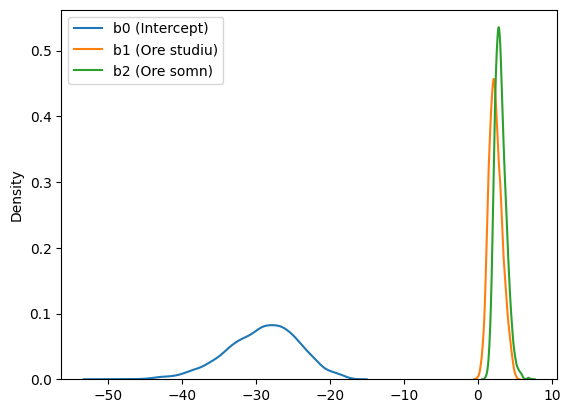

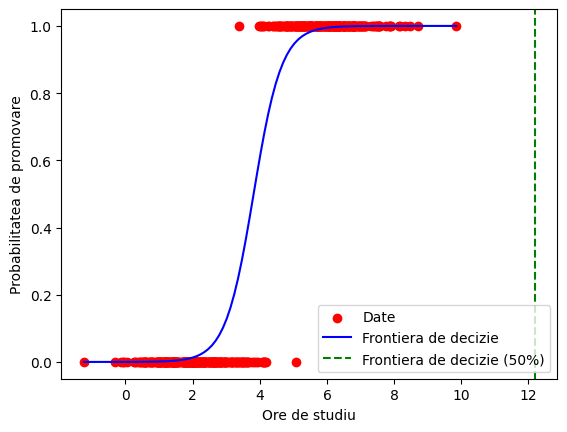

In [3]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Citirea datelor din fișierul CSV
data = pd.read_csv('date_promovare_examen.csv', delimiter=',')
study_hours = data['Ore_Studiu'].values
sleep_hours = data['Ore_Somn'].values
promote = data['Promovare'].values

# 2. Verificare balansare a datelor
promote_counts = pd.Series(promote).value_counts(normalize=True)
print(f"Proporția de promovare: {promote_counts}")

# 3. Modelul Bayesian de regresie logistică
with pm.Model() as logistic_model:
    # Distribuțiile a priori pentru coeficienți
    b0 = pm.Normal('b0', mu=0, sigma=10)  # Interceptul
    b1 = pm.Normal('b1', mu=0, sigma=10)  # Coeficient pentru ore_studiu
    b2 = pm.Normal('b2', mu=0, sigma=10)  # Coeficient pentru ore_somn
    
    # Probabilitatea de promovare (model logistic)
    logit_p = b0 + b1 * study_hours + b2 * sleep_hours
    p = pm.math.sigmoid(logit_p)
    
    # Observațiile (0 sau 1, cu probabilitatea p)
    y_obs = pm.Bernoulli('y_obs', p=p, observed=promote)
    
    # Posterior
    trace = pm.sample(2000, return_inferencedata=False)

# 4. Estimarea coeficienților b0, b1 și b2
b0_samples = trace['b0']
b1_samples = trace['b1']
b2_samples = trace['b2']

# 5. Calculul intervalelor de credibilitate (HDI)
b0_hdi = pm.stats.hdi(b0_samples)
b1_hdi = pm.stats.hdi(b1_samples)
b2_hdi = pm.stats.hdi(b2_samples)

print(f"Intervalul de credibilitate pentru b0: {b0_hdi}")
print(f"Intervalul de credibilitate pentru b1 (Ore studiu): {b1_hdi}")
print(f"Intervalul de credibilitate pentru b2 (Ore somn): {b2_hdi}")

# 6. Graficul distribuțiilor coeficienților
sns.kdeplot(b0_samples, label="b0 (Intercept)")
sns.kdeplot(b1_samples, label="b1 (Ore studiu)")
sns.kdeplot(b2_samples, label="b2 (Ore somn)")
plt.legend()
plt.show()

# 7. Calcularea frontierei de decizie
x_vals = np.linspace(min(study_hours), max(study_hours), 100)
fixed_sleep = np.mean(sleep_hours)  # Fixăm orele de somn la media lor
y_vals = np.mean(b0_samples) + np.mean(b1_samples) * x_vals + np.mean(b2_samples) * fixed_sleep

# Calcularea graniței de decizie pentru orele de studiu
decision_boundary = (-np.mean(b0_samples) - np.mean(b2_samples) * fixed_sleep) / np.mean(b1_samples)

# 8. Plotarea frontierei de decizie și a datelor
plt.scatter(study_hours, promote, color='red', label="Date")
plt.plot(x_vals, 1 / (1 + np.exp(-(y_vals))), label="Frontiera de decizie", color='blue')
plt.axvline(x=decision_boundary, color='green', linestyle='--', label="Frontiera de decizie (50%)")
plt.xlabel('Ore de studiu')
plt.ylabel('Probabilitatea de promovare')
plt.legend()
plt.show()

# 9. Interpretarea influenței variabilelor
if np.mean(b1_samples) > np.mean(b2_samples):
    print("Orele de studiu au un impact mai mare asupra promovabilității.")
else:
    print("Orele de somn au un impact mai mare asupra promovabilității.")
